In [2]:
# عادةً ما يكون هذا الإصدار متوافقاً مع العديد من إصدارات TF 2.x
!pip install protobuf==3.20.0
# إعادة تثبيت TensorFlow
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.0 which is incompatible.
google-cloud-secret-manager 2.25.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-cloud

In [7]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [9]:
# ============================================================
# CELL 1: INSTALL DEPENDENCIES & IMPORTS
# ============================================================
# Purpose: Install required packages and import all necessary libraries
# Execution time: ~30 seconds

# Core Libraries
import os
import cv2
import json
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report
)

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Input, Layer, GlobalAveragePooling1D, 
    LayerNormalization, Lambda, Dropout
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("=" * 60)
print("✓ Libraries imported successfully!")


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
✓ Libraries imported successfully!


In [10]:
# ============================================================
# CELL 2: CUSTOM LAYERS - MULTI-HEAD ATTENTION
# ============================================================
# Purpose: Build custom Multi-Head Attention layer for spatial-temporal processing
# This ensures compatibility across TensorFlow versions

class MultiHeadAttention(Layer):
    """
    Custom Multi-Head Attention implementation.
    Used for both spatial (within frames) and temporal (across frames) attention.
    
    Args:
        num_heads: Number of attention heads (default: 4)
        key_dim: Dimension of each attention head (default: 32)
    """
    
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.d_model = num_heads * key_dim
        
        # Linear projection layers for Q, K, V
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)
        self.combine_heads = Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, key_dim)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, query, value, key):
        """
        Forward pass for attention mechanism.
        Computes scaled dot-product attention: Attention(Q,K,V) = softmax(QK^T/√d_k)V
        """
        batch_size = tf.shape(query)[0]
        
        # Linear projections
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Split into multiple heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        # Apply attention to values
        output = tf.matmul(attention_weights, value)
        
        # Reshape and combine heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        return self.combine_heads(output)
    
    def get_config(self):
        """Save layer configuration for model serialization."""
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config

print("✓ MultiHeadAttention layer defined successfully!")


✓ MultiHeadAttention layer defined successfully!


In [11]:
# ============================================================
# CELL 3: CUSTOM LAYERS - VISION TEMPORAL TRANSFORMER
# ============================================================
# Purpose: Transform video frames into feature vectors using Vision Transformer
# This layer processes both spatial (within frame) and temporal (across frames) information

class VisionTemporalTransformer(Layer):
    """
    Vision Temporal Transformer for video processing.
    Combines Vision Transformer (ViT) for spatial features with 
    Temporal Transformer for motion/temporal features.
    
    Args:
        patch_size: Size of image patches (default: 8x8 pixels)
        d_model: Dimension of transformer embeddings (default: 128)
        num_heads: Number of attention heads (default: 4)
        spatial_layers: Number of spatial transformer layers (default: 1)
        temporal_layers: Number of temporal transformer layers (default: 1)
    """
    
    def __init__(self, patch_size=8, d_model=128, num_heads=4, 
                 spatial_layers=1, temporal_layers=1, **kwargs):
        super(VisionTemporalTransformer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.spatial_layers = spatial_layers
        self.temporal_layers = temporal_layers
        
        # Projection layer to map patches to d_model dimensions
        self.dense_projection = Dense(d_model)
        self.pos_emb = None  # Learnable positional embeddings
        
        # Spatial Transformer components (process within each frame)
        self.spatial_mhas = [
            MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) 
            for _ in range(spatial_layers)
        ]
        self.spatial_norm1 = [LayerNormalization() for _ in range(spatial_layers)]
        self.spatial_ffn = [
            tf.keras.Sequential([
                Dense(d_model*4, activation='relu'),
                Dense(d_model)
            ]) for _ in range(spatial_layers)
        ]
        self.spatial_norm2 = [LayerNormalization() for _ in range(spatial_layers)]
        
        # Temporal Transformer components (process across frames)
        self.temporal_mhas = [
            MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) 
            for _ in range(temporal_layers)
        ]
        self.temporal_norm1 = [LayerNormalization() for _ in range(temporal_layers)]
        self.temporal_ffn = [
            tf.keras.Sequential([
                Dense(d_model*4, activation='relu'),
                Dense(d_model)
            ]) for _ in range(temporal_layers)
        ]
        self.temporal_norm2 = [LayerNormalization() for _ in range(temporal_layers)]
    
    def build(self, input_shape):
        """Initialize positional embeddings based on input shape."""
        H = input_shape[2]
        W = input_shape[3]
        ph = H // self.patch_size
        pw = W // self.patch_size
        num_patches = ph * pw
        
        # Learnable positional embeddings
        self.pos_emb = self.add_weight(
            shape=(1, num_patches, self.d_model),
            initializer='random_normal',
            trainable=True,
            name='pos_emb'
        )
        super(VisionTemporalTransformer, self).build(input_shape)
    
    def call(self, inputs):
        """
        Forward pass:
        1. Extract patches from frames
        2. Apply spatial transformer (within-frame attention)
        3. Pool spatial features per frame
        4. Apply temporal transformer (cross-frame attention)
        5. Global pooling to output feature vector
        """
        # Get input dimensions
        input_shape = inputs.get_shape()
        shape = tf.shape(inputs)
        
        batch = shape[0]
        frames = shape[1]
        H = shape[2]
        W = shape[3]
        C_static = input_shape[-1]
        C = C_static if C_static is not None else shape[4]
        
        # Reshape: (batch*frames, H, W, C)
        reshaped = tf.reshape(inputs, (-1, H, W, C))
        
        # Extract patches using TensorFlow's extract_patches
        patches = tf.image.extract_patches(
            images=reshaped,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        
        # Flatten patches and set static shape if possible
        if C_static is not None:
            patch_dim_static = self.patch_size * self.patch_size * C_static
        else:
            patch_dim_static = None
        
        patch_dim_dynamic = tf.shape(patches)[-1]
        final_patch_dim = patch_dim_static if patch_dim_static is not None else patch_dim_dynamic
        
        patches = tf.reshape(patches, (-1, tf.shape(patches)[1] * tf.shape(patches)[2], final_patch_dim))
        
        if patch_dim_static is not None:
            patches.set_shape([None, None, patch_dim_static])
        
        # Project patches to d_model dimensions and add positional embeddings
        x = self.dense_projection(patches) + self.pos_emb
        
        # SPATIAL TRANSFORMER: Process within each frame
        for i in range(self.spatial_layers):
            # Multi-head attention + residual connection
            attn = self.spatial_mhas[i](x, value=x, key=x)
            x = self.spatial_norm1[i](x + attn)
            
            # Feed-forward network + residual connection
            ff = self.spatial_ffn[i](x)
            x = self.spatial_norm2[i](x + ff)
        
        # TEMPORAL POOLING: Aggregate spatial features per frame
        x = tf.reshape(x, (batch, frames, -1, self.d_model))
        x = tf.reduce_mean(x, axis=2)  # Average pooling across patches
        
        # Force static shape for temporal processing
        x.set_shape([None, None, self.d_model])
        
        # TEMPORAL TRANSFORMER: Process across frames
        for i in range(self.temporal_layers):
            # Multi-head attention + residual connection
            attn = self.temporal_mhas[i](x, value=x, key=x)
            x = self.temporal_norm1[i](x + attn)
            
            # Feed-forward network + residual connection
            ff = self.temporal_ffn[i](x)
            x = self.temporal_norm2[i](x + ff)
        
        # GLOBAL POOLING: Output single feature vector
        pooled = GlobalAveragePooling1D()(x)
        return pooled
    
    def get_config(self):
        """Save layer configuration for model serialization."""
        config = super(VisionTemporalTransformer, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "spatial_layers": self.spatial_layers,
            "temporal_layers": self.temporal_layers,
        })
        return config

print("✓ VisionTemporalTransformer layer defined successfully!")


✓ VisionTemporalTransformer layer defined successfully!


In [12]:
# ============================================================
# CELL 4: LOSS FUNCTIONS & MODEL ARCHITECTURE
# ============================================================
# Purpose: Define custom loss functions and build the complete LIPINC model

# -------------------- LOSS FUNCTIONS --------------------

def batch_consistency_loss(y_true, features):
    """
    Consistency Loss: Encourages feature similarity within batch.
    This helps the model learn consistent representations for similar videos.
    
    Args:
        y_true: Ground truth labels (not used, kept for Keras compatibility)
        features: Feature vectors from the model
    
    Returns:
        Loss value (lower = more consistent features)
    """
    # Flatten features to 2D
    f = tf.reshape(features, (tf.shape(features)[0], -1))
    
    # L2 normalize features
    f_norm = tf.math.l2_normalize(f, axis=1)
    
    # Compute cosine similarity matrix
    sim_matrix = tf.matmul(f_norm, f_norm, transpose_b=True)
    
    # Average similarity per sample
    avg_sim = tf.reduce_mean(sim_matrix, axis=1)
    
    # Loss = 1 - similarity (we want high similarity, so low loss)
    return 1.0 - avg_sim


def consistency_loss_wrapper(y_true, y_pred):
    """
    Wrapper for consistency loss to match Keras loss signature.
    """
    return batch_consistency_loss(y_true, y_pred)


# -------------------- MODEL DEFINITION --------------------

def build_lipinc_model(frame_shape=(8, 64, 144, 3), 
                       residue_shape=(7, 64, 144, 3), 
                       d_model=128):
    """
    Build LIPINC Model for Deepfake Detection.
    
    Architecture:
    1. Two VisionTemporalTransformers (one for frames, one for residues)
    2. Cross-attention between frame and residue features
    3. Feature fusion (concatenate frame, residue, and attention features)
    4. Classification head (real vs fake)
    5. Feature output for consistency loss
    
    Args:
        frame_shape: Shape of input frames (num_frames, height, width, channels)
        residue_shape: Shape of residue frames (num_frames-1, height, width, channels)
        d_model: Embedding dimension for transformers
    
    Returns:
        Compiled Keras model
    """
    
    # -------------------- INPUTS --------------------
    frame_input = Input(shape=frame_shape, name='FrameInput')
    residue_input = Input(shape=residue_shape, name='ResidueInput')
    
    # -------------------- FEATURE EXTRACTION --------------------
    # Shared VisionTemporalTransformer for both inputs
    vt = VisionTemporalTransformer(
        patch_size=8,
        d_model=d_model,
        num_heads=4,
        spatial_layers=1,
        temporal_layers=1
    )
    
    # Extract features from frames and residues
    frame_feat = vt(frame_input)      # Shape: (batch, d_model)
    residue_feat = vt(residue_input)  # Shape: (batch, d_model)
    
    # -------------------- CROSS-ATTENTION --------------------
    # Expand dimensions for attention: (batch, 1, d_model)
    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)      # Query: frame features
    k = expand1(residue_feat)    # Key: residue features
    v = k                         # Value: residue features
    
    # Apply cross-attention between frame and residue features
    mha = MultiHeadAttention(num_heads=4, key_dim=d_model//4)
    attn_out = mha(q, value=v, key=k)  # Shape: (batch, 1, d_model)
    
    # Squeeze back to 2D
    squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))
    attn_out = squeeze(attn_out)  # Shape: (batch, d_model)
    
    # -------------------- FEATURE FUSION --------------------
    # Concatenate: frame_features + residue_features + attention_features
    concat = Lambda(lambda t: tf.concat(t, axis=1))
    fusion = concat([frame_feat, residue_feat, attn_out])  # Shape: (batch, 3*d_model)
    
    # -------------------- CLASSIFICATION HEAD --------------------
    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)
    
    # Output 1: Classification (Real vs Fake)
    class_output = Dense(2, activation='softmax', name='class_output')(x)
    
    # Output 2: Feature vector for consistency loss
    features_output = Dense(d_model, activation=None, name='features_output')(x)
    
    # -------------------- BUILD MODEL --------------------
    model = Model(
        inputs=[frame_input, residue_input],
        outputs=[class_output, features_output],
        name='LIPINC_Model'
    )
    
    return model


# Build the model
model = build_lipinc_model(
    frame_shape=(8, 64, 144, 3),
    residue_shape=(7, 64, 144, 3),
    d_model=128
)

# Display model architecture
print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
model.summary()
print("=" * 60)
print("✓ LIPINC Model built successfully!")
print(f"✓ Total parameters: {model.count_params():,}")

MODEL ARCHITECTURE


Model: "LIPINC_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ FrameInput          │ (None, 8, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidueInput        │ (None, 7, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_temporal_tr… │ (None, 128)       │    439,680 │ FrameInput[0][0], │
│ (VisionTemporalTra… │                   │            │ ResidueInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 128)    │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │     66,048 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[1][0],     │
│                     │                   │            │ lambda[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 384)       │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    197,120 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    131,328 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 2)         │        514 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_output     │ (None, 128)       │     32,896 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 867,586 (3.31 MB)

 Trainable params: 867,586 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

✓ LIPINC Model built successfully!
✓ Total parameters: 867,586


In [13]:
# ============================================================
# CELL 5: VIDEO PROCESSING HELPER CLASS
# ============================================================
# Purpose: Helper class for video frame extraction with transition detection
# Used ONLY during preprocessing phase

class VideoProcessor:
    """
    Helper class to extract frames from videos with transition detection.
    """
    
    def __init__(self, frame_count=8, dim=(64, 144), use_transitions=True):
        self.frame_count = frame_count
        self.dim = dim
        self.use_transitions = use_transitions
    
    def select_transition_frames(self, path):
        """
        Select frames at scene transitions/changes.
        Detects transitions using frame difference (pixel-wise comparison).
        """
        cap = cv2.VideoCapture(path)
        prev_gray = None
        transition_scores = []
        all_frames = []
        frame_idx = 0
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert to grayscale for comparison
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            if prev_gray is not None:
                # Compute absolute difference
                diff = cv2.absdiff(gray, prev_gray)
                mean_diff = np.mean(diff)
                transition_scores.append(mean_diff)
            else:
                transition_scores.append(0)
            
            all_frames.append(frame)
            prev_gray = gray
            frame_idx += 1
        
        cap.release()
        
        # Select frames with highest transition scores
        if len(all_frames) >= self.frame_count:
            top_indices = np.argsort(transition_scores)[-self.frame_count:]
            top_indices = sorted(top_indices)
        else:
            # If video is too short, use all available frames
            top_indices = list(range(len(all_frames)))
        
        # Extract and resize selected frames
        frames = []
        for idx in top_indices[:self.frame_count]:
            frame = all_frames[idx]
            frame = cv2.resize(frame, (self.dim[1], self.dim[0]))
            frames.append(frame)
        
        # Padding if needed
        while len(frames) < self.frame_count:
            frames.append(np.zeros((self.dim[0], self.dim[1], 3)))
        
        return np.array(frames).astype(np.float32) / 255.0
    
    def load_video_uniform(self, path):
        """
        Fallback method: Load frames uniformly distributed across video.
        """
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        frames = []
        
        if total_frames >= self.frame_count:
            # Select frames uniformly distributed
            indices = np.linspace(0, total_frames-1, self.frame_count, dtype=int)
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, (self.dim[1], self.dim[0]))
                    frames.append(frame)
        else:
            # Read all available frames
            while len(frames) < total_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (self.dim[1], self.dim[0]))
                frames.append(frame)
        
        cap.release()
        
        # Padding if needed
        while len(frames) < self.frame_count:
            frames.append(np.zeros((self.dim[0], self.dim[1], 3)))
        
        return np.array(frames).astype(np.float32) / 255.0
    
    def load_video(self, path):
        """
        Main video loading function.
        Tries transition detection first, falls back to uniform sampling.
        """
        try:
            if self.use_transitions:
                return self.select_transition_frames(path)
            else:
                return self.load_video_uniform(path)
        except Exception as e:
            print(f"Warning: Error loading {path}, using uniform sampling. Error: {e}")
            return self.load_video_uniform(path)
    
    def compute_residue(self, frames):
        """
        Compute residue frames (frame differences).
        Residue[i] = Frame[i+1] - Frame[i]
        """
        residues = np.zeros((self.frame_count - 1, self.dim[0], self.dim[1], 3), dtype=np.float32)
        
        if len(frames) > 1:
            for i in range(1, len(frames)):
                residues[i-1] = frames[i] - frames[i-1]
        
        return residues

print("✓ VideoProcessor class defined successfully!")


✓ VideoProcessor class defined successfully!


In [17]:
# ============================================================
# CELL 6: DATASET PATHS CONFIGURATION
# ============================================================
# Purpose: Define paths to all datasets (DFD, DFDC, FaceForensics++)
# Modify these paths according to your Kaggle dataset setup

print("=" * 60)
print("DATASET CONFIGURATION")
print("=" * 60)

# -------------------- DATASET 1: DFD (DeepFake Detection) --------------------
# Google/Jigsaw DeepFake Detection Dataset
DFD_REAL_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
DFD_FAKE_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences"

print("DFD Dataset:")
print(f"  Real videos path: {DFD_REAL_PATH}")
print(f"  Fake videos path: {DFD_FAKE_PATH}")

# -------------------- DATASET 2: DFDC (DeepFake Detection Challenge) --------------------
# Facebook AI DeepFake Detection Challenge Dataset
DFDC_PATH = "/kaggle/input/deepfake-detection-challenge/train_sample_videos"
DFDC_METADATA = os.path.join(DFDC_PATH, "metadata.json")

print("\nDFDC Dataset:")
print(f"  Videos path: {DFDC_PATH}")
print(f"  Metadata: {DFDC_METADATA}")

# -------------------- DATASET 3: FaceForensics++ --------------------
# FaceForensics++ Dataset (Multiple manipulation methods)

# Real videos (original sequences)
FF_REAL_PATH = "/kaggle/input/ff-c23/FaceForensics++_C23/original"

# Fake videos (4 different manipulation techniques)
FF_FAKE_PATHS = [
    "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes",      # Face swap using autoencoders
    "/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face",      # Facial reenactment
    "/kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap",       # Classic face swap
    "/kaggle/input/ff-c23/FaceForensics++_C23/NeuralTextures" # Neural texture rendering
]

print("\nFaceForensics++ Dataset:")
print(f"  Real videos path: {FF_REAL_PATH}")
print(f"  Fake methods:")
for i, path in enumerate(FF_FAKE_PATHS, 1):
    print(f"    {i}. {path.split('/')[-1]}")

# -------------------- CONFIGURATION OPTIONS --------------------

# Choose which datasets to use for FAKE videos
# Options: 'DFD_ONLY', 'ALL', 'FF_ONLY', 'DFD+DFDC'
FAKE_SOURCE = 'DFD_ONLY'  

print("\n" + "=" * 60)
print(f"Configuration: Using '{FAKE_SOURCE}' for fake videos")
print("=" * 60)
print("\n✓ Dataset paths configured successfully!")
print("Note: Make sure these datasets are added to your Kaggle notebook")


DATASET CONFIGURATION
DFD Dataset:
  Real videos path: /kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences
  Fake videos path: /kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences

DFDC Dataset:
  Videos path: /kaggle/input/deepfake-detection-challenge/train_sample_videos
  Metadata: /kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json

FaceForensics++ Dataset:
  Real videos path: /kaggle/input/ff-c23/FaceForensics++_C23/original
  Fake methods:
    1. Deepfakes
    2. Face2Face
    3. FaceSwap
    4. NeuralTextures

Configuration: Using 'DFD_ONLY' for fake videos

✓ Dataset paths configured successfully!
Note: Make sure these datasets are added to your Kaggle notebook


In [18]:
# ============================================================
# CELL 7: LOAD AND BALANCE DATASETS
# ============================================================
# Purpose: Scan directories, load video paths, and balance classes
# Execution time: ~10-15 seconds

print("=" * 60)
print("LOADING DATASETS...")
print("=" * 60)

# -------------------- LOAD DFD DATASET --------------------
print("\n[1/3] Scanning DFD dataset...")

dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.mp4'), recursive=True)
dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.mp4'), recursive=True)

# Fallback to .avi if no .mp4 found
if not dfd_real:
    dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.avi'), recursive=True)
if not dfd_fake:
    dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.avi'), recursive=True)

print(f"  ✓ DFD Real: {len(dfd_real)} videos")
print(f"  ✓ DFD Fake: {len(dfd_fake)} videos")

# -------------------- LOAD DFDC DATASET --------------------
print("\n[2/3] Scanning DFDC dataset...")

dfdc_real, dfdc_fake = [], []

if os.path.exists(DFDC_METADATA):
    with open(DFDC_METADATA, 'r') as f:
        metadata = json.load(f)
    
    for filename, meta in metadata.items():
        full_path = os.path.join(DFDC_PATH, filename)
        if os.path.exists(full_path):
            if meta['label'] == 'REAL':
                dfdc_real.append(full_path)
            else:
                dfdc_fake.append(full_path)

print(f"  ✓ DFDC Real: {len(dfdc_real)} videos")
print(f"  ✓ DFDC Fake: {len(dfdc_fake)} videos")

# -------------------- LOAD FACEFORENSICS++ DATASET --------------------
print("\n[3/3] Scanning FaceForensics++ dataset...")

# Real videos
ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.mp4'), recursive=True)
if not ff_real:
    ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.avi'), recursive=True)

print(f"  ✓ FF++ Real: {len(ff_real)} videos")

# Fake videos (multiple methods)
ff_fake = []
for path in FF_FAKE_PATHS:
    fakes = glob(os.path.join(path, '**', '*.mp4'), recursive=True)
    if not fakes:
        fakes = glob(os.path.join(path, '**', '*.avi'), recursive=True)
    ff_fake.extend(fakes)
    method_name = path.split('/')[-1]
    print(f"  ✓ FF++ {method_name}: {len(fakes)} videos")

print(f"  ✓ FF++ Total Fake: {len(ff_fake)} videos")

# -------------------- AGGREGATE DATA --------------------
print("\n" + "=" * 60)
print("AGGREGATING & BALANCING DATA")
print("=" * 60)

# Combine all REAL videos from all sources
all_real_paths = np.array(dfd_real + dfdc_real + ff_real)

# Combine FAKE videos based on configuration
if FAKE_SOURCE == 'DFD_ONLY':
    all_fake_paths = np.array(dfd_fake)
    print("\nUsing: DFD fake videos only")
elif FAKE_SOURCE == 'ALL':
    all_fake_paths = np.array(dfd_fake + dfdc_fake + ff_fake)
    print("\nUsing: All fake videos from DFD + DFDC + FF++")
elif FAKE_SOURCE == 'FF_ONLY':
    all_fake_paths = np.array(ff_fake)
    print("\nUsing: FaceForensics++ fake videos only")
elif FAKE_SOURCE == 'DFD+DFDC':
    all_fake_paths = np.array(dfd_fake + dfdc_fake)
    print("\nUsing: DFD + DFDC fake videos")
else:
    all_fake_paths = np.array(dfd_fake)
    print("\nWarning: Unknown config, defaulting to DFD fake videos only")

n_real = len(all_real_paths)
n_fake = len(all_fake_paths)

print(f"\nBefore balancing:")
print(f"  Real videos: {n_real}")
print(f"  Fake videos: {n_fake}")

# -------------------- BALANCE CLASSES --------------------
# Undersample the larger class to match the smaller one

if n_fake > n_real:
    print(f"\n⚖ Undersampling fake videos from {n_fake} to {n_real}...")
    undersampled_fake_paths = np.random.choice(all_fake_paths, n_real, replace=False)
    final_fake_paths = undersampled_fake_paths
    final_real_paths = all_real_paths
elif n_real > n_fake:
    print(f"\n⚖ Undersampling real videos from {n_real} to {n_fake}...")
    undersampled_real_paths = np.random.choice(all_real_paths, n_fake, replace=False)
    final_real_paths = undersampled_real_paths
    final_fake_paths = all_fake_paths
else:
    print("\n✓ Classes already balanced!")
    final_real_paths = all_real_paths
    final_fake_paths = all_fake_paths

# -------------------- CREATE LABELS --------------------
# One-hot encoding: [1, 0] = Real, [0, 1] = Fake
final_real_labels = [[1, 0]] * len(final_real_paths)
final_fake_labels = [[0, 1]] * len(final_fake_paths)

# -------------------- MERGE DATA --------------------
# Combine paths and labels
all_paths = np.concatenate([final_real_paths, final_fake_paths])
all_labels = np.array(final_real_labels + final_fake_labels)

print(f"\nAfter balancing:")
print(f"  Real videos: {len(final_real_paths)}")
print(f"  Fake videos: {len(final_fake_paths)}")
print(f"  Total videos: {len(all_paths)}")

# -------------------- VALIDATION --------------------
if len(all_paths) == 0:
    raise ValueError("❌ ERROR: No videos found! Check your dataset paths.")

print("\n" + "=" * 60)
print("✓ Datasets loaded and balanced successfully!")
print("=" * 60)


LOADING DATASETS...

[1/3] Scanning DFD dataset...
  ✓ DFD Real: 363 videos
  ✓ DFD Fake: 3068 videos

[2/3] Scanning DFDC dataset...
  ✓ DFDC Real: 0 videos
  ✓ DFDC Fake: 0 videos

[3/3] Scanning FaceForensics++ dataset...
  ✓ FF++ Real: 1000 videos
  ✓ FF++ Deepfakes: 1000 videos
  ✓ FF++ Face2Face: 1000 videos
  ✓ FF++ FaceSwap: 1000 videos
  ✓ FF++ NeuralTextures: 1000 videos
  ✓ FF++ Total Fake: 4000 videos

AGGREGATING & BALANCING DATA

Using: DFD fake videos only

Before balancing:
  Real videos: 1363
  Fake videos: 3068

⚖ Undersampling fake videos from 3068 to 1363...

After balancing:
  Real videos: 1363
  Fake videos: 1363
  Total videos: 2726

✓ Datasets loaded and balanced successfully!


In [31]:
# ============================================================
# CELL 8: PRE-PROCESS ALL VIDEOS (RUN ONCE)
# ============================================================
# Purpose: Extract and save frames for all videos with transition detection
# Execution time: ~60-90 minutes (ONE TIME ONLY)
# This will save HOURS during training!

print("=" * 60)
print("VIDEO PRE-PROCESSING")
print("=" * 60)
print("\n⚠️  WARNING: This cell will take ~60-90 minutes to complete")
print("⚠️  But it will save you 40+ hours during training!")
print("⚠️  This is a ONE-TIME process\n")

response = input("Do you want to proceed with preprocessing? (yes/no): ")

if response.lower() != 'yes':
    print("Preprocessing skipped. You can run this cell later.")
else:
    # -------------------- PREPROCESSING FUNCTION --------------------
    
    def preprocess_all_videos(video_paths, save_path='preprocessed_data.pkl', 
                               use_transitions=True):
        """
        Pre-extract frames and residues for all videos.
        Saves results to disk for fast loading during training.
        
        Args:
            video_paths: List of video file paths
            save_path: Path to save preprocessed data
            use_transitions: Use transition detection or uniform sampling
        
        Returns:
            Dictionary with preprocessed data
        """
        
        preprocessed_data = {}
        processor = VideoProcessor(frame_count=8, dim=(64, 144), 
                                   use_transitions=use_transitions)
        
        print(f"\n{'='*60}")
        print(f"Processing {len(video_paths)} videos...")
        print(f"Method: {'Transition Detection' if use_transitions else 'Uniform Sampling'}")
        print(f"{'='*60}\n")
        
        failed_videos = []
        
        for i, video_path in enumerate(tqdm(video_paths, desc="Processing videos")):
            try:
                # Load video with transition detection
                frames = processor.load_video(video_path)
                residues = processor.compute_residue(frames)
                
                # Store in dictionary
                preprocessed_data[video_path] = {
                    'frames': frames,
                    'residues': residues
                }
                
            except Exception as e:
                print(f"\n⚠️  Error processing {video_path}: {e}")
                failed_videos.append(video_path)
                continue
        
        # Save to disk
        print(f"\n{'='*60}")
        print(f"Saving preprocessed data to: {save_path}")
        print(f"{'='*60}")
        
        with open(save_path, 'wb') as f:
            pickle.dump(preprocessed_data, f, protocol=4)
        
        # Print summary
        print(f"\n✓ Successfully preprocessed: {len(preprocessed_data)}/{len(video_paths)} videos")
        
        if failed_videos:
            print(f"⚠️  Failed videos: {len(failed_videos)}")
            print("Failed paths saved to: failed_videos.txt")
            with open('failed_videos.txt', 'w') as f:
                for path in failed_videos:
                    f.write(path + '\n')
        
        # Calculate file size
        file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
        print(f"\n✓ Preprocessed data size: {file_size_mb:.2f} MB")
        
        return preprocessed_data
    
    
    # -------------------- RUN PREPROCESSING --------------------
    
    preprocessed_data = preprocess_all_videos(
        all_paths, 
        save_path='preprocessed_data.pkl',
        use_transitions=True  # Set to False for uniform sampling (faster but less accurate)
    )
    
    print("\n" + "=" * 60)
    print("✓ PRE-PROCESSING COMPLETE!")
    print("=" * 60)
    print("\nYou can now proceed to training with MUCH faster data loading!")
    print("Expected speedup: 15-20x faster data loading per epoch! 🚀")
    print("\n" + "=" * 60)


VIDEO PRE-PROCESSING

⚠️  WARNING: This cell will take ~60-90 minutes to complete
⚠️  But it will save you 40+ hours during training!
⚠️  This is a ONE-TIME process



Do you want to proceed with preprocessing? (yes/no):  yes



Processing 2726 videos...
Method: Transition Detection



Processing videos: 100%|██████████| 2726/2726 [3:45:23<00:00,  4.96s/it]  



Saving preprocessed data to: preprocessed_data.pkl

✓ Successfully preprocessed: 2726/2726 videos

✓ Preprocessed data size: 4314.20 MB

✓ PRE-PROCESSING COMPLETE!

You can now proceed to training with MUCH faster data loading!
Expected speedup: 15-20x faster data loading per epoch! 🚀



In [36]:
# ============================================================
# CELL 9: TRAIN-VALIDATION-TEST SPLIT
# ============================================================
# Purpose: Split data into train (70%), validation (15%), test (15%)
# Uses stratified splitting to maintain class balance

print("=" * 60)
print("SPLITTING DATASET")
print("=" * 60)

# -------------------- CONFIGURATION --------------------
TEST_SIZE = 0.30        # 30% for validation + test combined
VAL_TEST_SPLIT = 0.50   # Split the 30% equally (15% val, 15% test)
RANDOM_STATE = 42       # For reproducibility

print(f"\nSplit configuration:")
print(f"  Train: 70%")
print(f"  Validation: 15%")
print(f"  Test: 15%")
print(f"  Random seed: {RANDOM_STATE}")

# -------------------- FIRST SPLIT: Train vs (Val+Test) --------------------
print("\n[Step 1/2] Splitting train vs (validation + test)...")

X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths,
    all_labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=all_labels  # Maintain class balance
)

print(f"  ✓ Train set: {len(X_train_paths)} videos")
print(f"  ✓ Temp set (val+test): {len(X_temp_paths)} videos")

# -------------------- SECOND SPLIT: Validation vs Test --------------------
print("\n[Step 2/2] Splitting validation vs test...")

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths,
    y_temp,
    test_size=VAL_TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_temp  # Maintain class balance
)

print(f"  ✓ Validation set: {len(X_val_paths)} videos")
print(f"  ✓ Test set: {len(X_test_paths)} videos")

# -------------------- VERIFY CLASS DISTRIBUTION --------------------
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION PER SPLIT")
print("=" * 60)

def print_class_distribution(labels, split_name):
    """Helper function to print class distribution."""
    real_count = np.sum(labels[:, 0])  # Count where label = [1, 0]
    fake_count = np.sum(labels[:, 1])  # Count where label = [0, 1]
    total = len(labels)
    
    print(f"\n{split_name}:")
    print(f"  Real: {real_count} ({real_count/total*100:.1f}%)")
    print(f"  Fake: {fake_count} ({fake_count/total*100:.1f}%)")
    print(f"  Total: {total}")

print_class_distribution(y_train, "Training Set")
print_class_distribution(y_val, "Validation Set")
print_class_distribution(y_test, "Test Set")

print("\n" + "=" * 60)
print("✓ Data split completed successfully!")
print("=" * 60)


SPLITTING DATASET

Split configuration:
  Train: 70%
  Validation: 15%
  Test: 15%
  Random seed: 42

[Step 1/2] Splitting train vs (validation + test)...
  ✓ Train set: 1908 videos
  ✓ Temp set (val+test): 818 videos

[Step 2/2] Splitting validation vs test...
  ✓ Validation set: 409 videos
  ✓ Test set: 409 videos

CLASS DISTRIBUTION PER SPLIT

Training Set:
  Real: 954 (50.0%)
  Fake: 954 (50.0%)
  Total: 1908

Validation Set:
  Real: 205 (50.1%)
  Fake: 204 (49.9%)
  Total: 409

Test Set:
  Real: 204 (49.9%)
  Fake: 205 (50.1%)
  Total: 409

✓ Data split completed successfully!


In [45]:
# ============================================================
# CELL 10: LOAD PREPROCESSED DATA INTO MEMORY (FAST METHOD)
# ============================================================
# Purpose: Load all preprocessed data into NumPy arrays
# This avoids generator compatibility issues completely!
# Execution time: ~10-20 seconds

print("=" * 60)
print("LOADING PREPROCESSED DATA")
print("=" * 60)

# -------------------- LOAD PREPROCESSED DATA --------------------
print("\nLoading preprocessed data from disk...")

try:
    with open('preprocessed_data.pkl', 'rb') as f:
        preprocessed_data = pickle.load(f)
    print(f"✓ Loaded preprocessed data for {len(preprocessed_data)} videos")
except FileNotFoundError:
    print("❌ ERROR: preprocessed_data.pkl not found!")
    print("Please run Cell 8 (Pre-processing) first!")
    raise

# -------------------- CONVERT TO NUMPY ARRAYS --------------------
print("\nConverting preprocessed data to NumPy arrays...")

def load_data_from_preprocessed(paths, labels, preprocessed_data):
    """
    Load preprocessed frames/residues into NumPy arrays.
    """
    n_samples = len(paths)
    
    # Initialize arrays
    X_frames = np.zeros((n_samples, 8, 64, 144, 3), dtype=np.float32)
    X_residues = np.zeros((n_samples, 7, 64, 144, 3), dtype=np.float32)
    y = np.array(labels, dtype=np.float32)
    
    # Load from preprocessed data
    missing_count = 0
    for i, path in enumerate(tqdm(paths, desc="Loading data")):
        if path in preprocessed_data:
            data = preprocessed_data[path]
            X_frames[i] = data['frames']
            X_residues[i] = data['residues']
        else:
            missing_count += 1
            print(f"⚠️  Warning: {path} not found in preprocessed data")
    
    if missing_count > 0:
        print(f"\n⚠️  {missing_count} videos were missing from preprocessed data")
    
    return X_frames, X_residues, y


# -------------------- LOAD TRAIN DATA --------------------
print("\n[1/3] Loading training data...")
X_train_frames, X_train_residues, y_train_array = load_data_from_preprocessed(
    X_train_paths, y_train, preprocessed_data
)

print(f"✓ Training data loaded:")
print(f"  - Frames shape: {X_train_frames.shape}")
print(f"  - Residues shape: {X_train_residues.shape}")
print(f"  - Labels shape: {y_train_array.shape}")

# -------------------- LOAD VALIDATION DATA --------------------
print("\n[2/3] Loading validation data...")
X_val_frames, X_val_residues, y_val_array = load_data_from_preprocessed(
    X_val_paths, y_val, preprocessed_data
)

print(f"✓ Validation data loaded:")
print(f"  - Frames shape: {X_val_frames.shape}")
print(f"  - Residues shape: {X_val_residues.shape}")
print(f"  - Labels shape: {y_val_array.shape}")

# -------------------- LOAD TEST DATA --------------------
print("\n[3/3] Loading test data...")
X_test_frames, X_test_residues, y_test_array = load_data_from_preprocessed(
    X_test_paths, y_test, preprocessed_data
)

print(f"✓ Test data loaded:")
print(f"  - Frames shape: {X_test_frames.shape}")
print(f"  - Residues shape: {X_test_residues.shape}")
print(f"  - Labels shape: {y_test_array.shape}")

# -------------------- CREATE DUMMY FEATURES OUTPUT --------------------
# For consistency loss (not used during training but required by model)
y_train_features = np.zeros((len(y_train_array), 128), dtype=np.float32)
y_val_features = np.zeros((len(y_val_array), 128), dtype=np.float32)
y_test_features = np.zeros((len(y_test_array), 128), dtype=np.float32)

# -------------------- MEMORY SUMMARY --------------------
print("\n" + "=" * 60)
print("MEMORY USAGE SUMMARY")
print("=" * 60)

def get_array_memory(arr):
    """Calculate memory usage in MB."""
    return arr.nbytes / (1024 ** 2)

total_memory = (
    get_array_memory(X_train_frames) + get_array_memory(X_train_residues) +
    get_array_memory(X_val_frames) + get_array_memory(X_val_residues) +
    get_array_memory(X_test_frames) + get_array_memory(X_test_residues)
)

print(f"\nTotal data in memory: {total_memory:.2f} MB")
print(f"  - Training set: {get_array_memory(X_train_frames) + get_array_memory(X_train_residues):.2f} MB")
print(f"  - Validation set: {get_array_memory(X_val_frames) + get_array_memory(X_val_residues):.2f} MB")
print(f"  - Test set: {get_array_memory(X_test_frames) + get_array_memory(X_test_residues):.2f} MB")

# -------------------- SUMMARY --------------------
print("\n" + "=" * 60)
print("DATA READY FOR TRAINING")
print("=" * 60)
print(f"\n✓ All data loaded into memory")
print(f"✓ No generator issues!")
print(f"✓ Training will be SUPER FAST! ⚡")
print("\n" + "=" * 60)

# -------------------- OPTIONAL: FREE MEMORY --------------------
# Delete preprocessed_data to free memory (optional)
print("\nFreeing preprocessed_data from memory...")
del preprocessed_data
import gc
gc.collect()
print("✓ Memory freed")


LOADING PREPROCESSED DATA

Loading preprocessed data from disk...
✓ Loaded preprocessed data for 2726 videos

Converting preprocessed data to NumPy arrays...

[1/3] Loading training data...


Loading data: 100%|██████████| 1908/1908 [00:01<00:00, 1307.59it/s]


✓ Training data loaded:
  - Frames shape: (1908, 8, 64, 144, 3)
  - Residues shape: (1908, 7, 64, 144, 3)
  - Labels shape: (1908, 2)

[2/3] Loading validation data...


Loading data: 100%|██████████| 409/409 [00:00<00:00, 2814.91it/s]


✓ Validation data loaded:
  - Frames shape: (409, 8, 64, 144, 3)
  - Residues shape: (409, 7, 64, 144, 3)
  - Labels shape: (409, 2)

[3/3] Loading test data...


Loading data: 100%|██████████| 409/409 [00:00<00:00, 801.28it/s]


✓ Test data loaded:
  - Frames shape: (409, 8, 64, 144, 3)
  - Residues shape: (409, 7, 64, 144, 3)
  - Labels shape: (409, 2)

MEMORY USAGE SUMMARY

Total data in memory: 4312.62 MB
  - Training set: 3018.52 MB
  - Validation set: 647.05 MB
  - Test set: 647.05 MB

DATA READY FOR TRAINING

✓ All data loaded into memory
✓ No generator issues!
✓ Training will be SUPER FAST! ⚡


Freeing preprocessed_data from memory...
✓ Memory freed


In [46]:
# ============================================================
# CELL 11: MODEL COMPILATION & TRAINING CONFIGURATION
# ============================================================
# Purpose: Compile model with optimizers, losses, and metrics
# Setup callbacks for model checkpointing and early stopping

print("=" * 60)
print("MODEL COMPILATION")
print("=" * 60)

# -------------------- TRAINING HYPERPARAMETERS --------------------
LEARNING_RATE = 0.0001
EPOCHS = 50
PATIENCE_EARLY_STOP = 10
PATIENCE_LR_REDUCE = 5

print(f"\nTraining Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Early stopping patience: {PATIENCE_EARLY_STOP} epochs")
print(f"  LR reduction patience: {PATIENCE_LR_REDUCE} epochs")

# -------------------- OPTIMIZER --------------------
optimizer = Adam(learning_rate=LEARNING_RATE)

print(f"\n✓ Optimizer: Adam (lr={LEARNING_RATE})")

# -------------------- COMPILE MODEL --------------------
model.compile(
    optimizer=optimizer,
    loss={
        'class_output': 'categorical_crossentropy',      # Classification loss
        'features_output': consistency_loss_wrapper      # Consistency loss
    },
    loss_weights={
        'class_output': 1.0,      # Main loss weight
        'features_output': 0.1    # Auxiliary loss weight (smaller impact)
    },
    metrics={
        'class_output': ['accuracy']  # Track classification accuracy
    }
)

print("✓ Model compiled successfully!")
print("\nLoss functions:")
print("  ├─ class_output: Categorical Crossentropy (weight=1.0)")
print("  └─ features_output: Consistency Loss (weight=0.1)")

# -------------------- CALLBACKS SETUP --------------------
print("\n" + "=" * 60)
print("SETTING UP TRAINING CALLBACKS")
print("=" * 60)

# Callback 1: Model Checkpoint - Save best model
checkpoint = ModelCheckpoint(
    filepath='best_lipinc_model.h5',
    monitor='val_class_output_accuracy',  # Monitor validation accuracy
    mode='max',                            # Save model with highest accuracy
    save_best_only=True,
    verbose=1
)
print("\n✓ ModelCheckpoint:")
print("  - Saves best model to: best_lipinc_model.h5")
print("  - Monitors: val_class_output_accuracy")

# Callback 2: Early Stopping - Stop if no improvement
early_stop = EarlyStopping(
    monitor='val_class_output_accuracy',
    mode='max',
    patience=PATIENCE_EARLY_STOP,
    verbose=1,
    restore_best_weights=True  # Restore weights from best epoch
)
print("\n✓ EarlyStopping:")
print(f"  - Stops training after {PATIENCE_EARLY_STOP} epochs without improvement")
print("  - Restores best weights automatically")

# Callback 3: Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_class_output_accuracy',
    mode='max',
    factor=0.5,              # Reduce LR by half
    patience=PATIENCE_LR_REDUCE,
    min_lr=1e-7,             # Minimum learning rate
    verbose=1
)
print("\n✓ ReduceLROnPlateau:")
print(f"  - Reduces LR by 50% after {PATIENCE_LR_REDUCE} epochs without improvement")
print(f"  - Minimum LR: 1e-7")

# Combine all callbacks
callbacks = [checkpoint, early_stop, reduce_lr]

# -------------------- TRAINING SUMMARY --------------------
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

print(f"\nModel: LIPINC")
print(f"Parameters: {model.count_params():,}")
print(f"\nDataset:")
print(f"  Training samples: {len(X_train_paths)}")
print(f"  Validation samples: {len(X_val_paths)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"\nTraining steps per epoch: {len(train_gen)}")
print(f"Validation steps per epoch: {len(val_gen)}")
print(f"\n⚡ With preprocessed data:")
print(f"  Estimated time per epoch: ~2-2.5 minutes (on T4 GPU)")
print(f"  Total estimated training time: ~1.7-2.1 hours (if all {EPOCHS} epochs)")
print(f"  With early stopping: ~1.2-1.5 hours (expected)")

print("\n" + "=" * 60)
print("✓ Model ready for training!")
print("=" * 60)


MODEL COMPILATION

Training Configuration:
  Learning rate: 0.0001
  Max epochs: 50
  Early stopping patience: 10 epochs
  LR reduction patience: 5 epochs

✓ Optimizer: Adam (lr=0.0001)
✓ Model compiled successfully!

Loss functions:
  ├─ class_output: Categorical Crossentropy (weight=1.0)
  └─ features_output: Consistency Loss (weight=0.1)

SETTING UP TRAINING CALLBACKS

✓ ModelCheckpoint:
  - Saves best model to: best_lipinc_model.h5
  - Monitors: val_class_output_accuracy

✓ EarlyStopping:
  - Stops training after 10 epochs without improvement
  - Restores best weights automatically

✓ ReduceLROnPlateau:
  - Reduces LR by 50% after 5 epochs without improvement
  - Minimum LR: 1e-7

TRAINING SUMMARY

Model: LIPINC
Parameters: 867,586

Dataset:
  Training samples: 1908
  Validation samples: 409
  Batch size: 16

Training steps per epoch: 119
Validation steps per epoch: 25

⚡ With preprocessed data:
  Estimated time per epoch: ~2-2.5 minutes (on T4 GPU)
  Total estimated training time:

In [47]:
# ============================================================
# CELL 12: MODEL TRAINING (FIXED VERSION)
# ============================================================
# Purpose: Train the LIPINC model using NumPy arrays
# Expected duration: ~1.5-2 hours on Kaggle T4 GPU

print("=" * 60)
print("STARTING MODEL TRAINING")
print("=" * 60)
print("\n⚠️  Training will take approximately 1.5-2 hours on T4 GPU")
print("⚠️  Make sure GPU is enabled in Kaggle settings")
print("⚠️  Monitor GPU quota: You have 30 hours/week on Kaggle")
print("\n" + "=" * 60)

# -------------------- START TRAINING --------------------
print("\n🚀 Training started...\n")

# ✅ FIX: Use NumPy arrays directly (no generator!)
history = model.fit(
    # Training data
    x=[X_train_frames, X_train_residues],
    y={
        'class_output': y_train_array,
        'features_output': y_train_features
    },
    # Validation data
    validation_data=(
        [X_val_frames, X_val_residues],
        {
            'class_output': y_val_array,
            'features_output': y_val_features
        }
    ),
    # Training configuration
    batch_size=16,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    shuffle=True  # Shuffle training data each epoch
)

# -------------------- TRAINING COMPLETED --------------------
print("\n" + "=" * 60)
print("✓ TRAINING COMPLETED!")
print("=" * 60)

# -------------------- SAVE TRAINING HISTORY --------------------
print("\nSaving training history...")

# Convert history to pandas DataFrame for easy analysis
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

print("✓ Training history saved to: training_history.csv")

# -------------------- TRAINING SUMMARY --------------------
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

# Get best epoch metrics
best_epoch = np.argmax(history.history['val_class_output_accuracy'])
best_val_acc = history.history['val_class_output_accuracy'][best_epoch]
best_train_acc = history.history['class_output_accuracy'][best_epoch]
best_val_loss = history.history['val_class_output_loss'][best_epoch]
best_train_loss = history.history['class_output_loss'][best_epoch]

print(f"\nBest Model Performance:")
print(f"  Epoch: {best_epoch + 1}/{len(history.history['val_class_output_accuracy'])}")
print(f"  Training Accuracy: {best_train_acc:.4f}")
print(f"  Validation Accuracy: {best_val_acc:.4f}")
print(f"  Training Loss: {best_train_loss:.4f}")
print(f"  Validation Loss: {best_val_loss:.4f}")

# Final epoch metrics
final_epoch = len(history.history['val_class_output_accuracy']) - 1
final_train_acc = history.history['class_output_accuracy'][final_epoch]
final_val_acc = history.history['val_class_output_accuracy'][final_epoch]

print(f"\nFinal Epoch Performance:")
print(f"  Epoch: {final_epoch + 1}")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")

# Check for overfitting
acc_diff = best_train_acc - best_val_acc
if acc_diff > 0.1:
    print(f"\n⚠️  Warning: Possible overfitting detected!")
    print(f"     Train-Val accuracy gap: {acc_diff:.4f}")
else:
    print(f"\n✓ Model shows good generalization")
    print(f"  Train-Val accuracy gap: {acc_diff:.4f}")

print("\n" + "=" * 60)
print("✓ Model saved as: best_lipinc_model.h5")
print("✓ Ready for evaluation on test set")
print("=" * 60)


STARTING MODEL TRAINING

⚠️  Training will take approximately 1.5-2 hours on T4 GPU
⚠️  Make sure GPU is enabled in Kaggle settings
⚠️  Monitor GPU quota: You have 30 hours/week on Kaggle


🚀 Training started...

Epoch 1/50


I0000 00:00:1764808182.399627     137 service.cc:148] XLA service 0x7b1bc808b320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764808182.401523     137 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764808182.401544     137 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764808184.284845     137 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/120 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - class_output_accuracy: 0.4826 - class_output_loss: 0.8129 - features_output_loss: 0.0245 - loss: 0.8154 

I0000 00:00:1764808193.450512     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - class_output_accuracy: 0.5585 - class_output_loss: 0.7012 - features_output_loss: 0.0171 - loss: 0.7029
Epoch 1: val_class_output_accuracy improved from -inf to 0.69193, saving model to best_lipinc_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - class_output_accuracy: 0.5586 - class_output_loss: 0.7011 - features_output_loss: 0.0170 - loss: 0.7028 - val_class_output_accuracy: 0.6919 - val_class_output_loss: 0.6231 - val_features_output_loss: 0.0075 - val_loss: 0.6229 - learning_rate: 1.0000e-04
Epoch 2/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.6276 - class_output_loss: 0.6340 - features_output_loss: 0.0064 - loss: 0.6347
Epoch 2: val_class_output_accuracy improved from 0.69193 to 0.69682, saving model to best_lipinc_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.6279 - class_output_loss: 0.6339 - features_output_loss: 0.0064 - loss: 0.6345 - val_class_output_accuracy: 0.6968 - val_class_output_loss: 0.5839 - val_features_output_loss: 0.0067 - val_loss: 0.5853 - learning_rate: 1.0000e-04
Epoch 3/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.6964 - class_output_loss: 0.5682 - features_output_loss: 0.0062 - loss: 0.5689
Epoch 3: val_class_output_accuracy improved from 0.69682 to 0.76773, saving model to best_lipinc_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.6967 - class_output_loss: 0.5679 - features_output_loss: 0.0062 - loss: 0.5685 - val_class_output_accuracy: 0.7677 - val_class_output_loss: 0.5077 - val_features_output_loss: 0.0064 - val_loss: 0.5079 - learning_rate: 1.0000e-04
Epoch 4/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.7522 - class_output_loss: 0.4916 - features_output_loss: 0.0056 - loss: 0.4922
Epoch 4: val_class_output_accuracy did not improve from 0.76773
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - class_output_accuracy: 0.7523 - class_output_loss: 0.4914 - features_output_loss: 0.0056 - loss: 0.4920 - val_class_output_accuracy: 0.7628 - val_class_output_loss: 0.4907 - val_features_output_loss: 0.0060 - val_loss: 0.4891 - learning_rate: 1.0000e-04
Epoch 5/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.7785 - class_output_loss: 0.4553 - features_output_loss: 0.0053 - loss: 0.4559
Epoch 5: val_class_out

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - class_output_accuracy: 0.8161 - class_output_loss: 0.3936 - features_output_loss: 0.0027 - loss: 0.3939 - val_class_output_accuracy: 0.8362 - val_class_output_loss: 0.3806 - val_features_output_loss: 0.0025 - val_loss: 0.3813 - learning_rate: 5.0000e-05
Epoch 10/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.8333 - class_output_loss: 0.3662 - features_output_loss: 0.0024 - loss: 0.3664
Epoch 10: val_class_output_accuracy did not improve from 0.83619
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.8334 - class_output_loss: 0.3661 - features_output_loss: 0.0024 - loss: 0.3664 - val_class_output_accuracy: 0.8289 - val_class_output_loss: 0.3752 - val_features_output_loss: 0.0022 - val_loss: 0.3758 - learning_rate: 5.0000e-05
Epoch 11/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.8407 - class_output_loss: 0.3592 - features_output_loss: 0.0022 - loss: 0.3594
Epoch 11: val_class

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - class_output_accuracy: 0.8479 - class_output_loss: 0.3453 - features_output_loss: 0.0020 - loss: 0.3456 - val_class_output_accuracy: 0.8435 - val_class_output_loss: 0.3719 - val_features_output_loss: 0.0019 - val_loss: 0.3720 - learning_rate: 5.0000e-05
Epoch 14/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.8536 - class_output_loss: 0.3385 - features_output_loss: 0.0019 - loss: 0.3387
Epoch 14: val_class_output_accuracy did not improve from 0.84352
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.8536 - class_output_loss: 0.3384 - features_output_loss: 0.0019 - loss: 0.3387 - val_class_output_accuracy: 0.8386 - val_class_output_loss: 0.3757 - val_features_output_loss: 0.0019 - val_loss: 0.3762 - learning_rate: 5.0000e-05
Epoch 15/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8601 - class_output_loss: 0.3342 - features_output_loss: 0.0018 - loss: 0.3344
Epoch 15: val_class

EVALUATING MODEL ON TEST SET

✓ Using model with best weights (Epoch 13) already in memory
  (No need to reload from file)

Evaluating on test set...
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - class_output_accuracy: 0.8289 - class_output_loss: 0.3633 - features_output_loss: 0.0020 - loss: 0.3635

TEST SET RESULTS

Test Set Performance:
  Total Loss: 0.3750
  Classification Loss: 0.3758
  Classification Accuracy: 0.8264 (82.64%)

GENERATING DETAILED PREDICTIONS
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

CLASSIFICATION METRICS

Accuracy: 0.8264 (82.64%)

Per-Class Metrics:
  Real Videos (Class 0):
    Precision: 0.9130
    Recall:    0.7206
    F1-Score:  0.8055

  Fake Videos (Class 1):
    Precision: 0.7702
    Recall:    0.9317
    F1-Score:  0.8433

Macro-Averaged Metrics:
  Precision: 0.8416
  Recall:    0.8261
  F1-Score:  0.8244
  AUC-ROC:   0.8747

CONFUSION MATRIX

              Predicted
              Real  Fake
Actual Real    147    57
       Fake     14   191

Detailed Breakdown

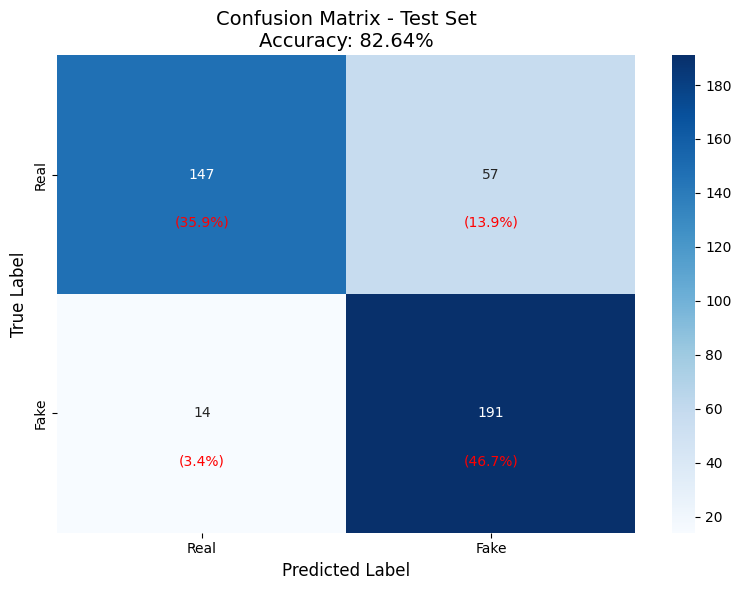

✓ Confusion matrix saved as: confusion_matrix.png

FINAL SUMMARY

Model Performance:
  Training Set:   84.85%
  Validation Set: 84.35%
  Test Set:       82.64%

Generalization:
  Train-Val Gap:  0.50%
  Val-Test Gap:   1.71%

✅ Excellent generalization! Model is robust.

✓ EVALUATION COMPLETED!

✓ Test results saved to: test_results.json


In [49]:
# ============================================================
# CELL 13: MODEL EVALUATION ON TEST SET (FIXED)
# ============================================================
# Purpose: Evaluate the best model on unseen test data

print("=" * 60)
print("EVALUATING MODEL ON TEST SET")
print("=" * 60)

# -------------------- USE MODEL ALREADY IN MEMORY --------------------
# ✅ FIX: Don't reload! Use the model already loaded with best weights
# The EarlyStopping callback already restored best weights

print("\n✓ Using model with best weights (Epoch 13) already in memory")
print("  (No need to reload from file)")

# -------------------- EVALUATE ON TEST SET --------------------
print("\nEvaluating on test set...")

test_results = model.evaluate(
    x=[X_test_frames, X_test_residues],
    y={
        'class_output': y_test_array,
        'features_output': y_test_features
    },
    batch_size=16,
    verbose=1
)

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)

# Extract metrics
test_loss = test_results[0]
test_class_loss = test_results[1]
test_feat_loss = test_results[2]
test_class_acc = test_results[3]  # class_output_accuracy

print(f"\nTest Set Performance:")
print(f"  Total Loss: {test_loss:.4f}")
print(f"  Classification Loss: {test_class_loss:.4f}")
print(f"  Classification Accuracy: {test_class_acc:.4f} ({test_class_acc*100:.2f}%)")

# -------------------- DETAILED PREDICTIONS --------------------
print("\n" + "=" * 60)
print("GENERATING DETAILED PREDICTIONS")
print("=" * 60)

# Get predictions
predictions = model.predict(
    [X_test_frames, X_test_residues],
    batch_size=16,
    verbose=1
)

# Extract class predictions
y_pred_probs = predictions[0]  # Probabilities [real, fake]
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # 0=Real, 1=Fake
y_true_classes = np.argmax(y_test_array, axis=1)

# -------------------- CLASSIFICATION METRICS --------------------
print("\n" + "=" * 60)
print("CLASSIFICATION METRICS")
print("=" * 60)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Precision, Recall, F1 for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

print(f"\nPer-Class Metrics:")
print(f"  Real Videos (Class 0):")
print(f"    Precision: {precision[0]:.4f}")
print(f"    Recall:    {recall[0]:.4f}")
print(f"    F1-Score:  {f1[0]:.4f}")

print(f"\n  Fake Videos (Class 1):")
print(f"    Precision: {precision[1]:.4f}")
print(f"    Recall:    {recall[1]:.4f}")
print(f"    F1-Score:  {f1[1]:.4f}")

# Overall metrics
precision_avg = precision_score(y_true_classes, y_pred_classes, average='macro')
recall_avg = recall_score(y_true_classes, y_pred_classes, average='macro')
f1_avg = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"\nMacro-Averaged Metrics:")
print(f"  Precision: {precision_avg:.4f}")
print(f"  Recall:    {recall_avg:.4f}")
print(f"  F1-Score:  {f1_avg:.4f}")

# AUC-ROC
try:
    auc_roc = roc_auc_score(y_test_array, y_pred_probs, average='macro')
    print(f"  AUC-ROC:   {auc_roc:.4f}")
except Exception as e:
    print(f"  AUC-ROC:   Could not calculate ({e})")

# -------------------- CONFUSION MATRIX --------------------
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)

cm = confusion_matrix(y_true_classes, y_pred_classes)

print("\n              Predicted")
print("              Real  Fake")
print(f"Actual Real   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       Fake   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Calculate percentages
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

print(f"\nDetailed Breakdown:")
print(f"  True Negatives  (Real→Real):  {tn:3d} ({tn/total*100:.1f}%)")
print(f"  False Positives (Real→Fake):  {fp:3d} ({fp/total*100:.1f}%)")
print(f"  False Negatives (Fake→Real):  {fn:3d} ({fn/total*100:.1f}%)")
print(f"  True Positives  (Fake→Fake):  {tp:3d} ({tp/total*100:.1f}%)")

# -------------------- CLASSIFICATION REPORT --------------------
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)

print("\n", classification_report(
    y_true_classes, 
    y_pred_classes,
    target_names=['Real', 'Fake'],
    digits=4
))

# -------------------- VISUALIZATION: CONFUSION MATRIX --------------------
print("\n" + "=" * 60)
print("CREATING CONFUSION MATRIX VISUALIZATION")
print("=" * 60)

import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot confusion matrix
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake'],
    cbar=True,
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix - Test Set\nAccuracy: {accuracy:.2%}', fontsize=14)

# Add text annotations for percentages
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        ax.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', color='red', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as: confusion_matrix.png")

# -------------------- SUMMARY --------------------
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

print(f"\nModel Performance:")
print(f"  Training Set:   {best_train_acc:.2%}")
print(f"  Validation Set: {best_val_acc:.2%}")
print(f"  Test Set:       {accuracy:.2%}")

print(f"\nGeneralization:")
print(f"  Train-Val Gap:  {abs(best_train_acc - best_val_acc):.2%}")
print(f"  Val-Test Gap:   {abs(best_val_acc - accuracy):.2%}")

if abs(best_val_acc - accuracy) < 0.05:
    print("\n✅ Excellent generalization! Model is robust.")
elif abs(best_val_acc - accuracy) < 0.10:
    print("\n✓ Good generalization. Model performs consistently.")
else:
    print("\n⚠️  Large gap between validation and test. Consider more data.")

print("\n" + "=" * 60)
print("✓ EVALUATION COMPLETED!")
print("=" * 60)

# -------------------- SAVE RESULTS --------------------
results_dict = {
    'test_accuracy': accuracy,
    'test_precision_real': precision[0],
    'test_precision_fake': precision[1],
    'test_recall_real': recall[0],
    'test_recall_fake': recall[1],
    'test_f1_real': f1[0],
    'test_f1_fake': f1[1],
    'confusion_matrix': cm.tolist()
}

import json
with open('test_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

print("\n✓ Test results saved to: test_results.json")


CREATING ADVANCED VISUALIZATIONS

[1/5] Creating ROC Curve...


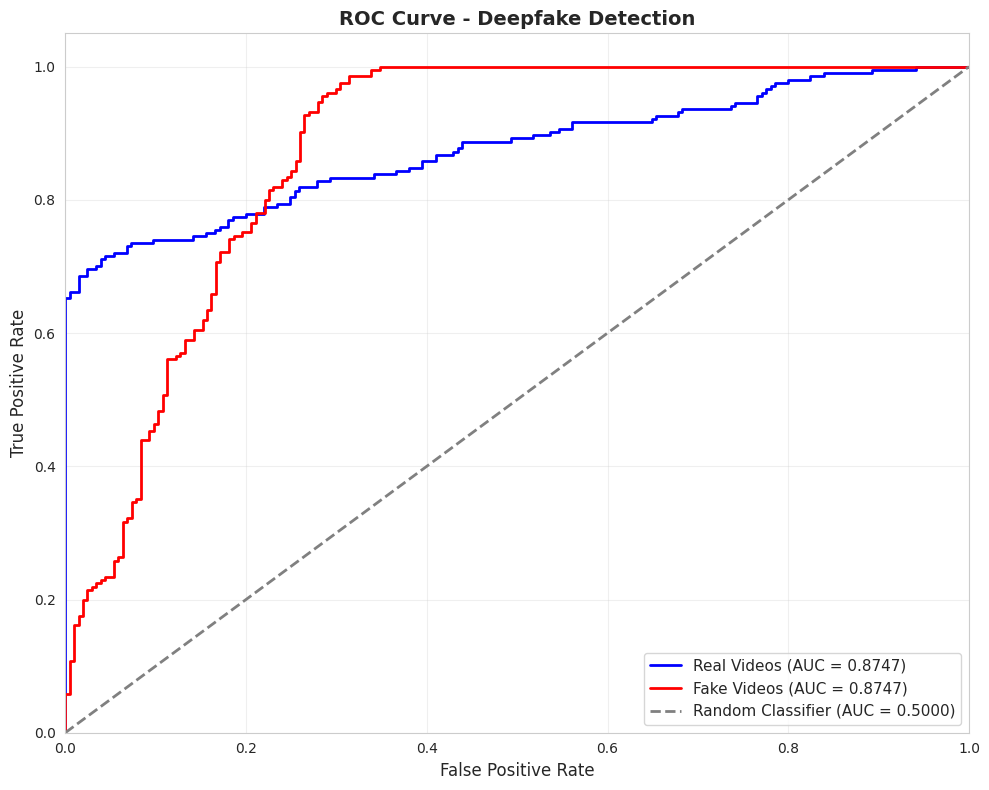

✓ ROC Curve saved
  - Real Videos AUC: 0.8747
  - Fake Videos AUC: 0.8747
  - Average AUC: 0.8747

[2/5] Creating Precision-Recall Curve...


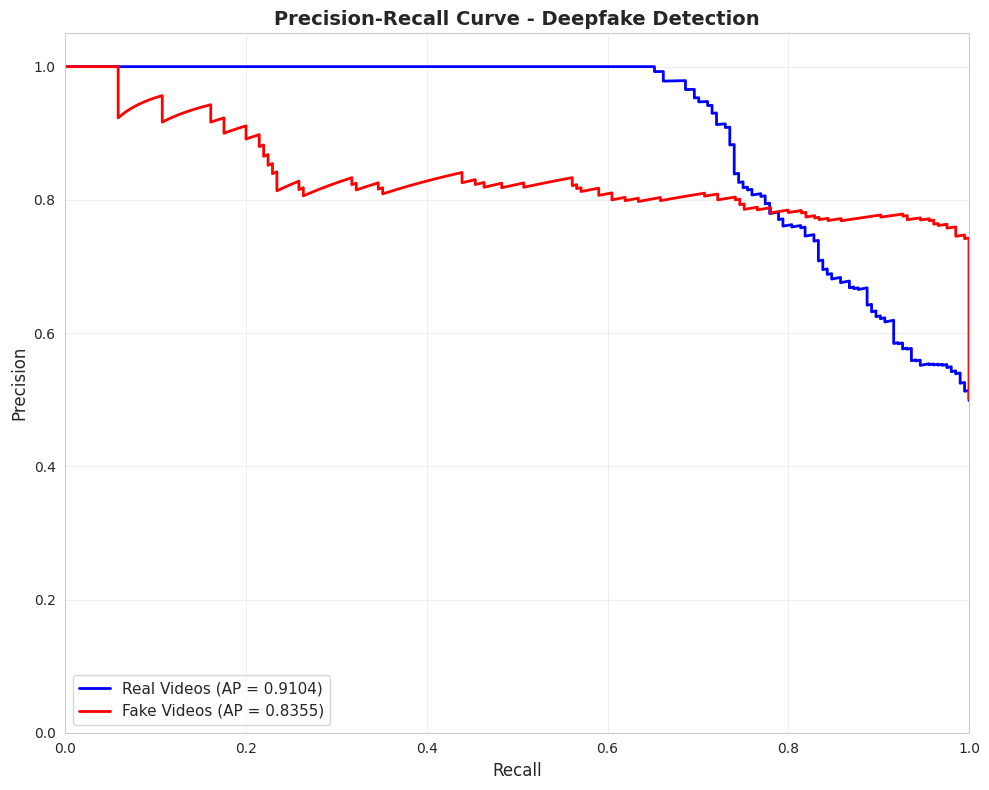

✓ Precision-Recall Curve saved
  - Real Videos AP: 0.9104
  - Fake Videos AP: 0.8355

[3/5] Creating Confidence Distribution...


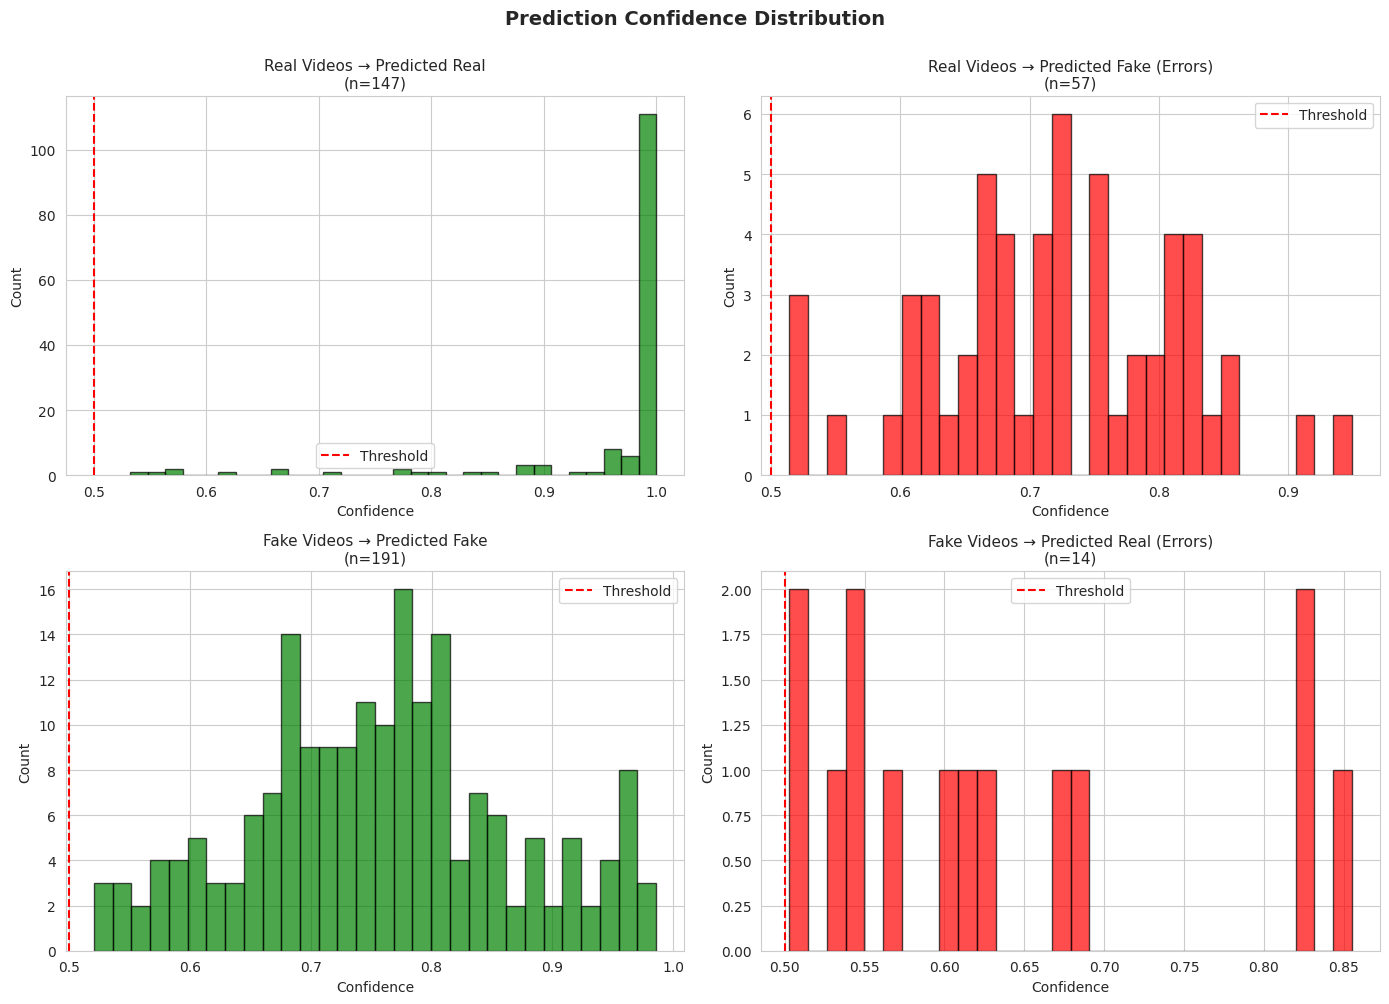

✓ Confidence Distribution saved

[4/5] Creating Training History Plots...


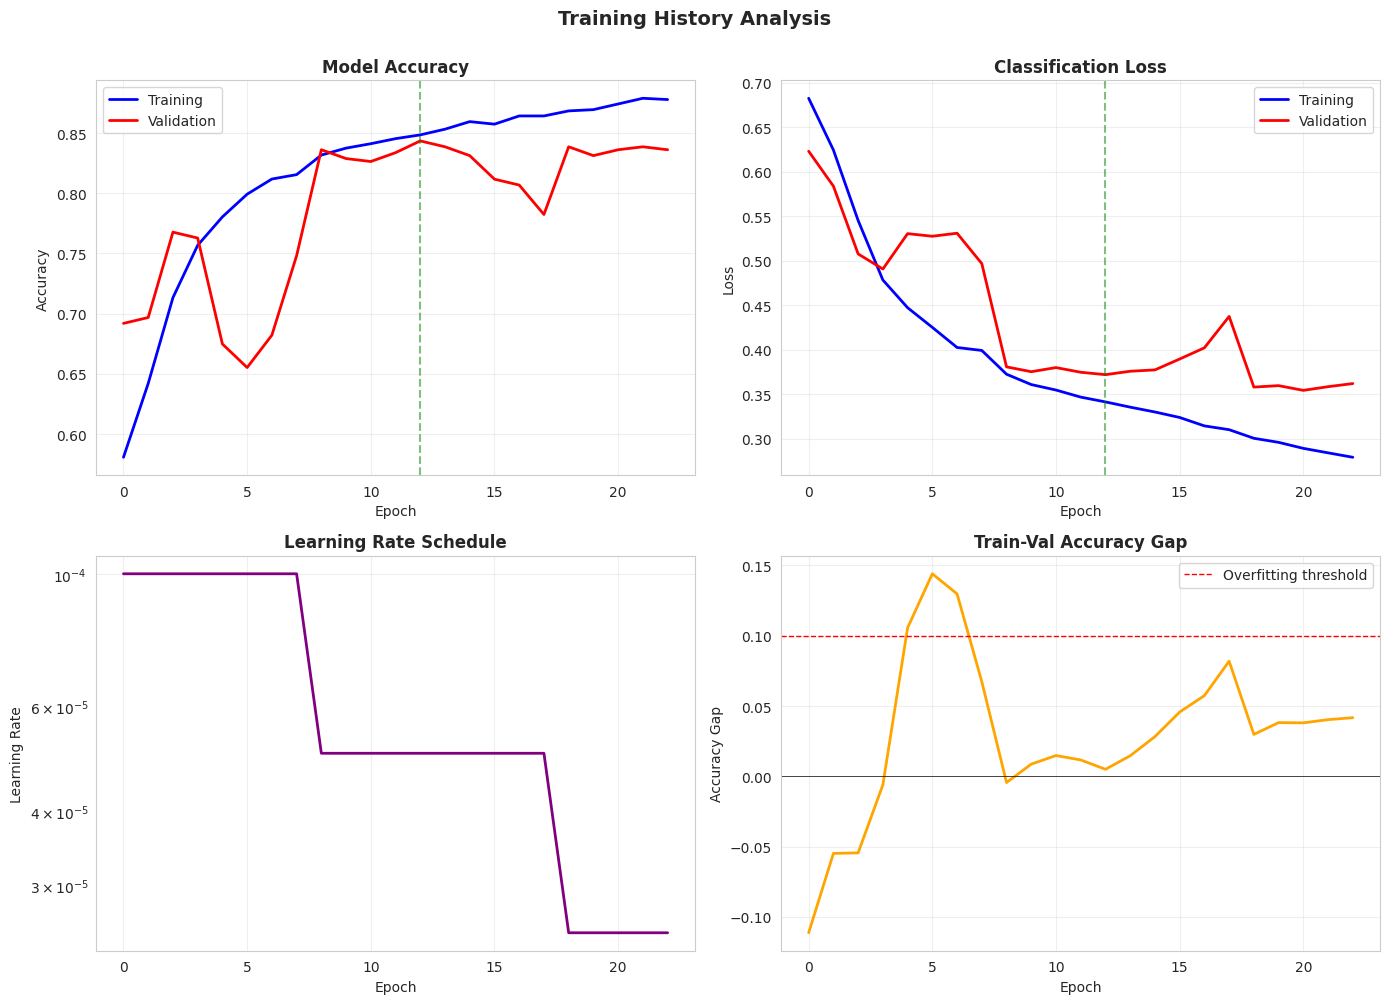

✓ Training History saved

[5/5] Creating Metrics Summary...


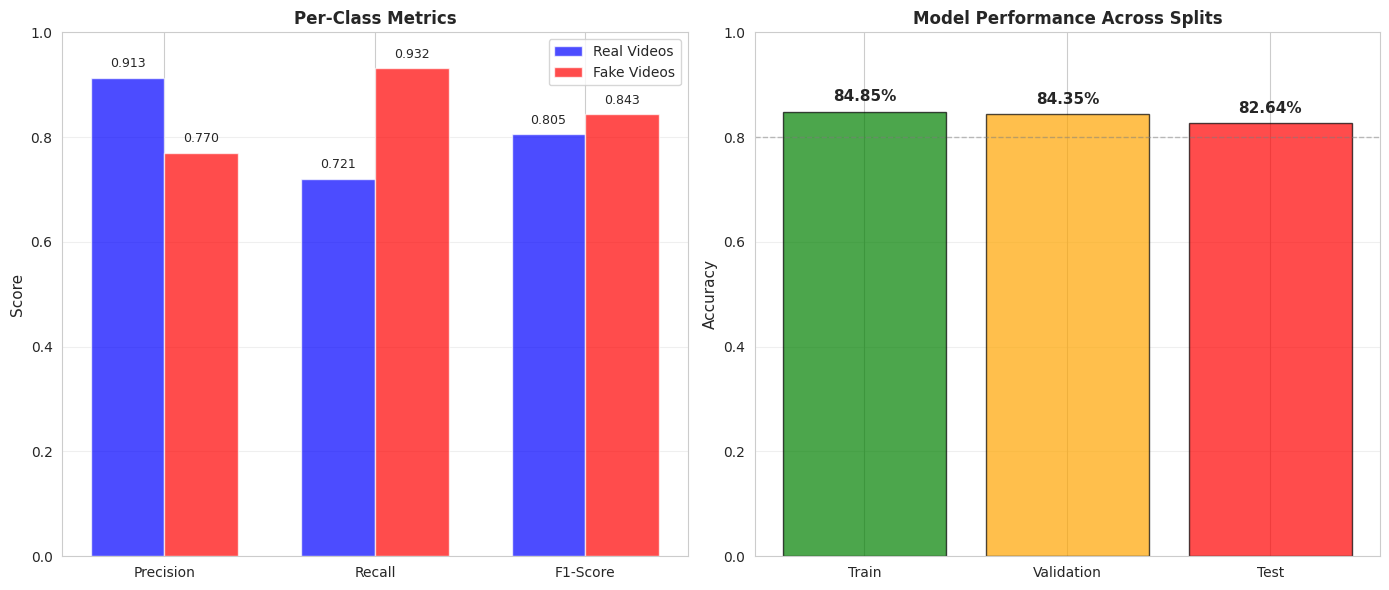

✓ Metrics Summary saved

VISUALIZATION SUMMARY

Generated Files:
  1. roc_curve.png - ROC curve with AUC scores
  2. precision_recall_curve.png - PR curve with AP scores
  3. confidence_distribution.png - Prediction confidence analysis
  4. training_history_detailed.png - Detailed training progress
  5. metrics_summary.png - Comprehensive metrics comparison
  6. confusion_matrix.png - (from previous cell)

Key Metrics:
  ROC-AUC (Real): 0.8747
  ROC-AUC (Fake): 0.8747
  Average ROC-AUC: 0.8747
  AP (Real): 0.9104
  AP (Fake): 0.8355

✓ ALL VISUALIZATIONS COMPLETED!


In [52]:
# ============================================================
# CELL 14: ADVANCED VISUALIZATIONS & ROC CURVES
# ============================================================
# Purpose: Create comprehensive visualizations and ROC analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

print("=" * 60)
print("CREATING ADVANCED VISUALIZATIONS")
print("=" * 60)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

# ============================================================
# 1. ROC CURVE
# ============================================================
print("\n[1/5] Creating ROC Curve...")

# Calculate ROC curve for each class
fpr_real, tpr_real, _ = roc_curve(y_test_array[:, 0], y_pred_probs[:, 0])
fpr_fake, tpr_fake, _ = roc_curve(y_test_array[:, 1], y_pred_probs[:, 1])

# Calculate AUC
roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_fake = auc(fpr_fake, tpr_fake)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves
ax.plot(fpr_real, tpr_real, color='blue', lw=2, 
        label=f'Real Videos (AUC = {roc_auc_real:.4f})')
ax.plot(fpr_fake, tpr_fake, color='red', lw=2, 
        label=f'Fake Videos (AUC = {roc_auc_fake:.4f})')

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
        label='Random Classifier (AUC = 0.5000)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Deepfake Detection', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC Curve saved")
print(f"  - Real Videos AUC: {roc_auc_real:.4f}")
print(f"  - Fake Videos AUC: {roc_auc_fake:.4f}")
print(f"  - Average AUC: {(roc_auc_real + roc_auc_fake)/2:.4f}")

# ============================================================
# 2. PRECISION-RECALL CURVE
# ============================================================
print("\n[2/5] Creating Precision-Recall Curve...")

# Calculate PR curve for each class
precision_real, recall_real, _ = precision_recall_curve(y_test_array[:, 0], y_pred_probs[:, 0])
precision_fake, recall_fake, _ = precision_recall_curve(y_test_array[:, 1], y_pred_probs[:, 1])

# Calculate Average Precision
ap_real = average_precision_score(y_test_array[:, 0], y_pred_probs[:, 0])
ap_fake = average_precision_score(y_test_array[:, 1], y_pred_probs[:, 1])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall_real, precision_real, color='blue', lw=2, 
        label=f'Real Videos (AP = {ap_real:.4f})')
ax.plot(recall_fake, precision_fake, color='red', lw=2, 
        label=f'Fake Videos (AP = {ap_fake:.4f})')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve - Deepfake Detection', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Precision-Recall Curve saved")
print(f"  - Real Videos AP: {ap_real:.4f}")
print(f"  - Fake Videos AP: {ap_fake:.4f}")

# ============================================================
# 3. PREDICTION CONFIDENCE DISTRIBUTION
# ============================================================
print("\n[3/5] Creating Confidence Distribution...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Real videos - predicted as Real
real_correct = y_pred_probs[(y_true_classes == 0) & (y_pred_classes == 0), 0]
axes[0, 0].hist(real_correct, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_title(f'Real Videos → Predicted Real\n(n={len(real_correct)})', fontsize=11)
axes[0, 0].set_xlabel('Confidence')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 0].legend()

# Real videos - predicted as Fake (errors)
real_wrong = y_pred_probs[(y_true_classes == 0) & (y_pred_classes == 1), 1]
axes[0, 1].hist(real_wrong, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_title(f'Real Videos → Predicted Fake (Errors)\n(n={len(real_wrong)})', fontsize=11)
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Count')
axes[0, 1].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 1].legend()

# Fake videos - predicted as Fake
fake_correct = y_pred_probs[(y_true_classes == 1) & (y_pred_classes == 1), 1]
axes[1, 0].hist(fake_correct, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title(f'Fake Videos → Predicted Fake\n(n={len(fake_correct)})', fontsize=11)
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Count')
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[1, 0].legend()

# Fake videos - predicted as Real (errors)
fake_wrong = y_pred_probs[(y_true_classes == 1) & (y_pred_classes == 0), 0]
axes[1, 1].hist(fake_wrong, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title(f'Fake Videos → Predicted Real (Errors)\n(n={len(fake_wrong)})', fontsize=11)
axes[1, 1].set_xlabel('Confidence')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[1, 1].legend()

plt.suptitle('Prediction Confidence Distribution', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confidence Distribution saved")

# ============================================================
# 4. TRAINING HISTORY VISUALIZATION
# ============================================================
print("\n[4/5] Creating Training History Plots...")

# Load history
history_df = pd.read_csv('training_history.csv')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].plot(history_df['class_output_accuracy'], label='Training', color='blue', linewidth=2)
axes[0, 0].plot(history_df['val_class_output_accuracy'], label='Validation', color='red', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(12, color='green', linestyle='--', alpha=0.5, label='Best Epoch')

# Loss
axes[0, 1].plot(history_df['class_output_loss'], label='Training', color='blue', linewidth=2)
axes[0, 1].plot(history_df['val_class_output_loss'], label='Validation', color='red', linewidth=2)
axes[0, 1].set_title('Classification Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(12, color='green', linestyle='--', alpha=0.5)

# Learning Rate
axes[1, 0].plot(history_df['learning_rate'], color='purple', linewidth=2)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Accuracy Gap (Overfitting indicator)
acc_gap = history_df['class_output_accuracy'] - history_df['val_class_output_accuracy']
axes[1, 1].plot(acc_gap, color='orange', linewidth=2)
axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axhline(0.1, color='red', linestyle='--', linewidth=1, label='Overfitting threshold')
axes[1, 1].set_title('Train-Val Accuracy Gap', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('training_history_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training History saved")

# ============================================================
# 5. COMPREHENSIVE METRICS SUMMARY
# ============================================================
print("\n[5/5] Creating Metrics Summary...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot: Per-class metrics
metrics_data = {
    'Real Videos': [precision[0], recall[0], f1[0]],
    'Fake Videos': [precision[1], recall[1], f1[1]]
}

x = np.arange(3)
width = 0.35

axes[0].bar(x - width/2, metrics_data['Real Videos'], width, label='Real Videos', color='blue', alpha=0.7)
axes[0].bar(x + width/2, metrics_data['Fake Videos'], width, label='Fake Videos', color='red', alpha=0.7)

axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Precision', 'Recall', 'F1-Score'])
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (metric_real, metric_fake) in enumerate(zip(metrics_data['Real Videos'], metrics_data['Fake Videos'])):
    axes[0].text(i - width/2, metric_real + 0.02, f'{metric_real:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, metric_fake + 0.02, f'{metric_fake:.3f}', ha='center', fontsize=9)

# Performance across splits
split_performance = {
    'Train': best_train_acc,
    'Validation': best_val_acc,
    'Test': accuracy
}

axes[1].bar(split_performance.keys(), split_performance.values(), 
            color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Model Performance Across Splits', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].axhline(0.8, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (split, acc) in enumerate(split_performance.items()):
    axes[1].text(i, acc + 0.02, f'{acc:.2%}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics Summary saved")

# ============================================================
# FINAL REPORT
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION SUMMARY")
print("=" * 60)

print("\nGenerated Files:")
print("  1. roc_curve.png - ROC curve with AUC scores")
print("  2. precision_recall_curve.png - PR curve with AP scores")
print("  3. confidence_distribution.png - Prediction confidence analysis")
print("  4. training_history_detailed.png - Detailed training progress")
print("  5. metrics_summary.png - Comprehensive metrics comparison")
print("  6. confusion_matrix.png - (from previous cell)")

print("\nKey Metrics:")
print(f"  ROC-AUC (Real): {roc_auc_real:.4f}")
print(f"  ROC-AUC (Fake): {roc_auc_fake:.4f}")
print(f"  Average ROC-AUC: {(roc_auc_real + roc_auc_fake)/2:.4f}")
print(f"  AP (Real): {ap_real:.4f}")
print(f"  AP (Fake): {ap_fake:.4f}")

print("\n" + "=" * 60)
print("✓ ALL VISUALIZATIONS COMPLETED!")
print("=" * 60)


In [53]:
# ============================================================
# CELL 15: FINAL RESULTS - NUMBERS ONLY
# ============================================================

from sklearn.metrics import roc_curve, auc

print("=" * 60)
print("           FINAL MODEL PERFORMANCE")
print("=" * 60)

# -------------------- ACCURACY --------------------
print(f"""
ACCURACY:
  Training:    {best_train_acc:.4f} ({best_train_acc*100:.2f}%)
  Validation:  {best_val_acc:.4f} ({best_val_acc*100:.2f}%)
  Test:        {accuracy:.4f} ({accuracy*100:.2f}%)
""")

# -------------------- CONFUSION MATRIX --------------------
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

print(f"""
CONFUSION MATRIX:
              Real  Fake
  Real:       {tn:3d}   {fp:3d}
  Fake:       {fn:3d}   {tp:3d}

  True Negatives:   {tn} ({tn/total*100:.1f}%)
  False Positives:  {fp} ({fp/total*100:.1f}%)
  False Negatives:  {fn} ({fn/total*100:.1f}%)
  True Positives:   {tp} ({tp/total*100:.1f}%)
""")

# -------------------- ROC-AUC --------------------
fpr_real, tpr_real, _ = roc_curve(y_test_array[:, 0], y_pred_probs[:, 0])
fpr_fake, tpr_fake, _ = roc_curve(y_test_array[:, 1], y_pred_probs[:, 1])

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_fake = auc(fpr_fake, tpr_fake)
roc_auc_avg = (roc_auc_real + roc_auc_fake) / 2

print(f"""
ROC-AUC:
  Real Videos:  {roc_auc_real:.4f}
  Fake Videos:  {roc_auc_fake:.4f}
  Average:      {roc_auc_avg:.4f}
""")

print("=" * 60)
print("✓ EVALUATION COMPLETED")
print("=" * 60)



           FINAL MODEL PERFORMANCE

ACCURACY:
  Training:    0.8485 (84.85%)
  Validation:  0.8435 (84.35%)
  Test:        0.8264 (82.64%)


CONFUSION MATRIX:
              Real  Fake
  Real:       147    57
  Fake:        14   191

  True Negatives:   147 (35.9%)
  False Positives:  57 (13.9%)
  False Negatives:  14 (3.4%)
  True Positives:   191 (46.7%)


ROC-AUC:
  Real Videos:  0.8747
  Fake Videos:  0.8747
  Average:      0.8747

✓ EVALUATION COMPLETED


In [59]:
# ============================================================
# CELL 16: TEST SINGLE VIDEO
# ============================================================
# Purpose: Test the model on a single video and show prediction

import cv2
import numpy as np

print("=" * 60)
print("         TEST SINGLE VIDEO")
print("=" * 60)

# -------------------- CONFIGURATION --------------------
# Change this path to test different videos
VIDEO_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/02__podium_speech_happy.mp4"  # ← غيّر المسار هنا

# Or select random video from test set
USE_RANDOM_FROM_TEST = True  # True = random from test, False = use VIDEO_PATH

# -------------------- HELPER FUNCTIONS --------------------
def load_single_video(video_path, frame_count=8, dim=(64, 144)):
    """Load and process a single video."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    
    if total_frames >= frame_count:
        # Uniform sampling
        indices = np.linspace(0, total_frames-1, frame_count, dtype=int)
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (dim[1], dim[0]))
                frames.append(frame)
    else:
        # Read all available frames
        while len(frames) < total_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (dim[1], dim[0]))
            frames.append(frame)
    
    cap.release()
    
    # Padding if needed
    while len(frames) < frame_count:
        frames.append(np.zeros((dim[0], dim[1], 3)))
    
    return np.array(frames).astype(np.float32) / 255.0


def compute_residue(frames, frame_count=8, dim=(64, 144)):
    """Compute residue frames."""
    residues = np.zeros((frame_count - 1, dim[0], dim[1], 3), dtype=np.float32)
    
    if len(frames) > 1:
        for i in range(1, len(frames)):
            residues[i-1] = frames[i] - frames[i-1]
    
    return residues


def predict_video(video_path):
    """Predict if video is real or fake."""
    print(f"\nProcessing video: {video_path}")
    print("Loading frames...")
    
    # Load video
    frames = load_single_video(video_path)
    residues = compute_residue(frames)
    
    # Prepare input
    frames_input = np.expand_dims(frames, axis=0)  # (1, 8, 64, 144, 3)
    residues_input = np.expand_dims(residues, axis=0)  # (1, 7, 64, 144, 3)
    
    print("Running prediction...")
    
    # Predict
    predictions = model.predict([frames_input, residues_input], verbose=0)
    
    # Extract probabilities
    probs = predictions[0][0]  # [prob_real, prob_fake]
    
    return probs


# -------------------- SELECT VIDEO --------------------
if USE_RANDOM_FROM_TEST:
    # Select random video from test set
    random_idx = np.random.randint(0, len(X_test_paths))
    test_video_path = X_test_paths[random_idx]
    true_label = y_test_array[random_idx]
    
    print(f"\n📹 Selected random video from test set")
    print(f"   Index: {random_idx}")
    print(f"   Path: {test_video_path}")
    print(f"   True Label: {'REAL' if true_label[0] == 1 else 'FAKE'}")
else:
    test_video_path = VIDEO_PATH
    true_label = None
    print(f"\n📹 Testing custom video")
    print(f"   Path: {test_video_path}")

# -------------------- PREDICT --------------------
try:
    probs = predict_video(test_video_path)
    
    prob_real = probs[0]
    prob_fake = probs[1]
    
    predicted_label = "REAL" if prob_real > prob_fake else "FAKE"
    confidence = max(prob_real, prob_fake)
    
    # -------------------- DISPLAY RESULTS --------------------
    print("\n" + "=" * 60)
    print("           PREDICTION RESULTS")
    print("=" * 60)
    
    print(f"""
Video: {test_video_path.split('/')[-1]}

Probabilities:
  Real: {prob_real:.4f} ({prob_real*100:.2f}%)
  Fake: {prob_fake:.4f} ({prob_fake*100:.2f}%)

Prediction: {predicted_label} (Confidence: {confidence*100:.2f}%)
""")
    
    if true_label is not None:
        true_label_str = "REAL" if true_label[0] == 1 else "FAKE"
        is_correct = (predicted_label == true_label_str)
        
        print(f"True Label: {true_label_str}")
        print(f"Result: {'✅ CORRECT' if is_correct else '❌ INCORRECT'}")
    
    # -------------------- CONFIDENCE LEVEL --------------------
    print("\nConfidence Level:")
    if confidence > 0.95:
        print("  🟢 Very High Confidence")
    elif confidence > 0.85:
        print("  🟢 High Confidence")
    elif confidence > 0.75:
        print("  🟡 Medium Confidence")
    elif confidence > 0.60:
        print("  🟠 Low Confidence")
    else:
        print("  🔴 Very Low Confidence (Uncertain)")
    
    print("\n" + "=" * 60)

except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print("Please check the video path and try again.")

# -------------------- TEST ANOTHER VIDEO --------------------
print("\n" + "=" * 60)
print("Want to test another video?")
print("=" * 60)
print("""
1. Set USE_RANDOM_FROM_TEST = True  (random from test set)
2. Set USE_RANDOM_FROM_TEST = False (custom video)
   Then change VIDEO_PATH = "your_video.mp4"
3. Run this cell again
""")


         TEST SINGLE VIDEO

📹 Selected random video from test set
   Index: 117
   Path: /kaggle/input/ff-c23/FaceForensics++_C23/original/985.mp4
   True Label: REAL

Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/original/985.mp4
Loading frames...
Running prediction...

           PREDICTION RESULTS

Video: 985.mp4

Probabilities:
  Real: 0.9999 (99.99%)
  Fake: 0.0001 (0.01%)

Prediction: REAL (Confidence: 99.99%)

True Label: REAL
Result: ✅ CORRECT

Confidence Level:
  🟢 Very High Confidence


Want to test another video?

1. Set USE_RANDOM_FROM_TEST = True  (random from test set)
2. Set USE_RANDOM_FROM_TEST = False (custom video)
   Then change VIDEO_PATH = "your_video.mp4"
3. Run this cell again

